In [1]:
import os
from functools import partial

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
import jax.numpy as jnp
import numpy as np
import wandb
from dalle_mini import DalleBart, DalleBartProcessor
from flax.jax_utils import replicate
from flax.training.common_utils import shard_prng_key
from PIL import Image
from vqgan_jax.modeling_flax_vqgan import VQModel

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:v14"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None
DALLE_MODEL = wandb.Api().artifact(DALLE_MODEL).download()
# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_REPO_NEW = "ttj/vqgan-anime"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"
# Load Bart
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

# Load vqgan
vqgan, vqgan_params = VQModel.from_pretrained(VQGAN_REPO_NEW, _do_init=False)
vqgan, vqgan_params_old = VQModel.from_pretrained(VQGAN_REPO, _do_init=False)

wandb: Downloading large artifact mega-1-fp16:v14, 4938.53MB. 7 files... Done. 0:0:0.1
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at ./artifacts/mega-1-fp16:v14:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_1', 'k_proj', 'kernel'), ('mo

In [2]:
params = replicate(params)
vqgan_params = replicate(vqgan_params)
vqgan_params_old = replicate(vqgan_params_old)

In [3]:
# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

# stack two vqgan params, so we can decode with both at the same time
# creates a new axis at the end
two_vqgan_parmas = jax.tree_map(
    lambda x, y: jnp.stack([x, y], axis=-1), vqgan_params_old, vqgan_params
)
p_decode_m = jax.vmap(p_decode, in_axes=(None, -1), out_axes=(-1))


In [4]:
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0


def generate(prompts, seed):
    key = jax.random.PRNGKey(seed)
    tokenized_prompt = processor(prompts)
    tokenized_prompt = replicate(tokenized_prompt)
    # generate image
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(key),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    encoded_images = encoded_images.sequences[..., 1:]
    return encoded_images


def to_image(encoding: "d b 1"):
    out = p_decode(encoding, vqgan_params).clip(0, 1)
    # out: d b h w c
    return Image.fromarray(
        np.asarray(out[0, 0] * 255, dtype=np.uint8).reshape(256, 256, 3)
    )


def demo(prompt, seed=0):
    encoding = generate([prompt], seed=seed)
    image = to_image(encoding)
    return image

/home/ttj/miniconda3/envs/anime/lib/python3.7/site-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  FutureWarning)


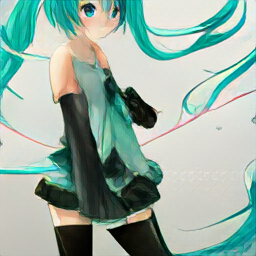

In [5]:
demo("Hatsune Miku")

In [6]:
from einops import rearrange



# generate 2 images at the same time
def to_image2(encoding):
    out = p_decode_m(encoding, two_vqgan_parmas).clip(0, 1)
    # out: d b h w c m
    out = rearrange(out, "d b h w c m -> d b h (m w) c").clip(0.0, 1.0)
    return Image.fromarray(
        np.asarray(out[0, 0] * 255, dtype=np.uint8).reshape(256, 512, 3)
    )


def demo2(prompt, seed=0):
    encoding = generate([prompt], seed=seed)
    image = to_image2(encoding)
    return image

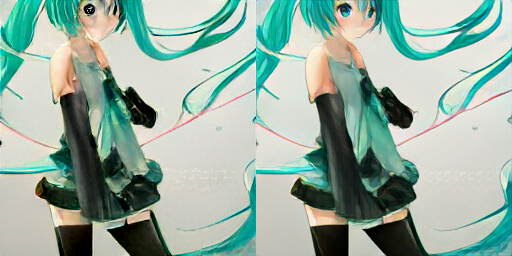

In [7]:
demo2("Hatsune Miku")

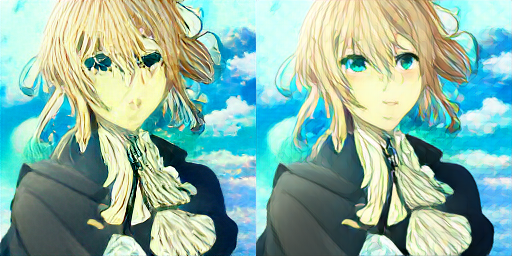

In [8]:
demo2("Violet Evergarden")

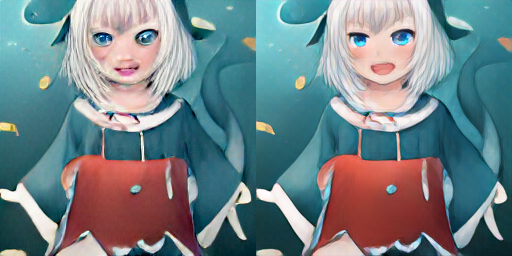

In [9]:
demo2("Vtuber Gawr Gura")

In [10]:
encoding = generate(["Hatsune Miku"], seed=0)

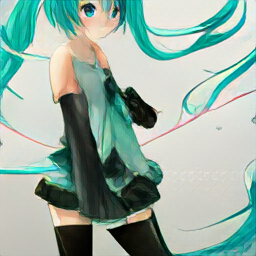

In [11]:
to_image(encoding)

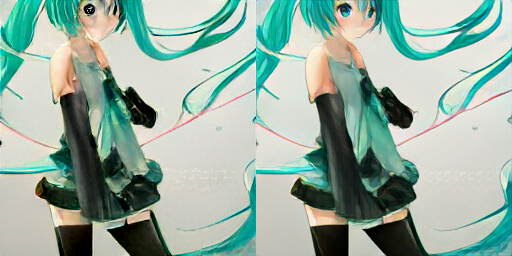

In [12]:
to_image2(encoding)

In [13]:
# use this to split the image into two and save it
def split_images(img):
    img1 = np.asarray(img)[:, :256, :]
    img2 = np.asarray(img)[:, 256:, :]
    return img1, img2